In [0]:
from google.colab import drive
ROOT = "/content/drive/"
drive.mount(ROOT)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import numpy as np
from os.path import join
from importlib.machinery import SourceFileLoader
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from warnings import simplefilter
simplefilter("ignore", category=ConvergenceWarning)
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

PROJ = "My Drive/Colab Notebooks/P13-VSN with AE/"
PROJECT_PATH = join(ROOT, PROJ)
clusterizer = SourceFileLoader('somelib', join(PROJECT_PATH, 'clusterizer.py')).load_module()
DEC = SourceFileLoader('somelib', join(PROJECT_PATH, 'DEC.py')).load_module()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
Using TensorFlow backend.


100%|██████████| 10000/10000 [00:02<00:00, 3862.49it/s]


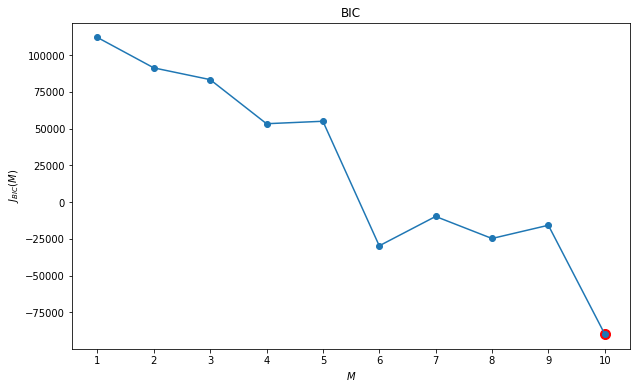

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


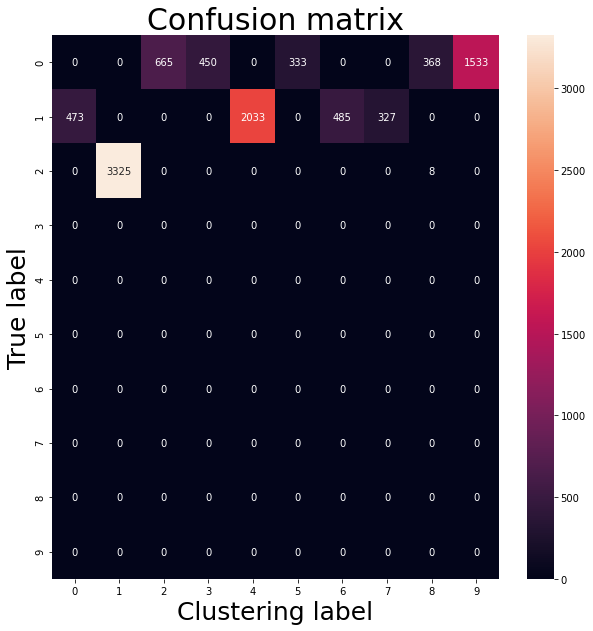

GMM acc: 0.689


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


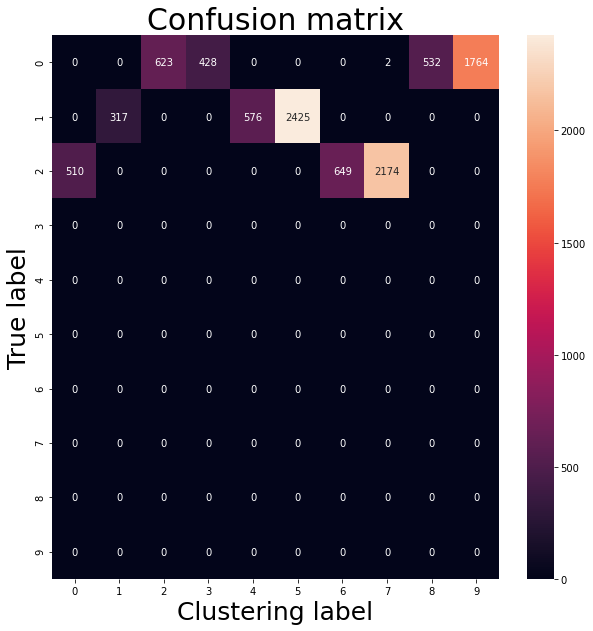

V-GMM acc: 0.636


In [0]:
# SETUP PARAMETERS

# define the number of events and their a-priori probability
M = 3  
events = range(M)
p_events = (1/M)*np.ones(M) # suppose uniform distribution over the events

# define the number of nodes
N = 30

# maximum number of events
M_max = 10

# define the triggering model
scale_separator = 1
tau = scale_separator*np.random.randint(0,2,size=(M,N)) # m-th row has the nodes triggerd by the m-th event
while np.linalg.matrix_rank(tau) < M: # suppose M < N
  tau = scale_separator*np.random.randint(0,2,size=(M,N))
# explore underlying triggering structure
# print("\ntau = \n", tau)

# GENERATE MEASUREMENTS (DATASET)

# define the success probability for each node (success = correct measurement)
p_succ = 0.8

# number of measurements
n = 10000
h = np.empty((n,N)) # i-th row is the i-th measurement (N-dim binary vector)
labels = [] # collect the groundtruth labels (i.e., triggering events)
confidence_range = [0.7,1.0]
for i in tqdm(range(n)): 
  # randomly choose one of the M events acting at the i-th measurement
  event = np.random.choice(events, 1, p=p_events)
  labels.append(event)
  v_i = np.zeros(N) # noise
  for node in range(N):
    if not np.random.binomial(1,p_succ): # success is a Bernoulli process of success probability p_succ
      v_i[node] = scale_separator if np.random.binomial(1,0.5) else -scale_separator
      # v_i[node] *= np.random.uniform(confidence_error_range[0],confidence_error_range[1]) # smooth the error by the detection confidence
  h[i,:] = np.multiply(np.minimum(np.maximum( tau[event,:]+ v_i,0),scale_separator),np.random.uniform(confidence_range[0],confidence_range[1],N))
# h = np.minimum(h,scale_separator)
# explore measurements
# print("h= \n", h)
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection='3d')
# plt.scatter(h[:, 0], h[:, 1], s=50)

# CLUSTERING OF MEASUREMENTS
# GMM 
M_range = range(1,M_max+1)
gmm = clusterizer.GMM()  
gmm = clusterizer.GMM(gmm.GMM_generation(h, M_range,type='standard', want_to_plot= True)) # fit on data
labels_gmm = gmm.prediction(h) # prediction
cm_gmm,acc_gmm,ind_gmm = gmm.confusion_matrix(labels, labels_gmm, True) # confusion matrix
gmm.gmm_model.weights_ = gmm.gmm_model.weights_[ind_gmm[:,1]]
gmm.gmm_model.means_ = gmm.gmm_model.means_[ind_gmm[:,1]]
gmm.gmm_model.covariances_ = gmm.gmm_model.covariances_[ind_gmm[:,1]]
print("GMM acc: %5.3f" %(acc_gmm))

# V-GMM 
vgmm = clusterizer.GMM()  
vgmm = clusterizer.GMM(vgmm.GMM_generation(h, M_range,type='bayesian', weight_concentration_prior_type='dirichlet_process', weight_concentration_prior=1.0E-7, want_to_plot= True)) # fit on data
labels_vgmm = vgmm.prediction(h) # prediction
cm_vgmm,acc_vgmm,ind_vgmm = vgmm.confusion_matrix(labels, labels_vgmm, True) # confusion matrix
vgmm.gmm_model.weights_ = vgmm.gmm_model.weights_[ind_vgmm[:,1]]
vgmm.gmm_model.means_ = vgmm.gmm_model.means_[ind_vgmm[:,1]]
vgmm.gmm_model.covariances_ = vgmm.gmm_model.covariances_[ind_vgmm[:,1]]
print("V-GMM acc: %5.3f" %(acc_vgmm))

# Kmeans
# K_range = M_range
# kmeans = clusterizer.kMeans()  
# models = kmeans.kmeans_generation(h,K_range, True) # fit models on data
# best_model_idx = M#-1
# while best_model_idx not in K_range:
#   best_model_idx = int(input("Number of clusters? "))
# kmeans = clusterizer.kMeans(models[best_model_idx-1]) # select best model
# labels_kmeans = kmeans.prediction(h) # prediction
# cm_kmeans, acc_kmeans, ind_kmeans = kmeans.confusion_matrix(labels, labels_kmeans, True) # confusion matrix
# print("KMeans acc: %5.3f" %(acc_kmeans))


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 22)                682       
_________________________________________________________________
dense_2 (Dense)              (None, 15)                345       
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 112       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 16        
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 21        
_________________________________________________________________
dense_6 (Dense)              (None, 15)                120 

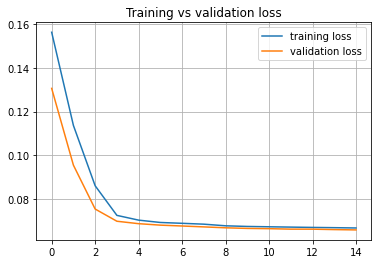

In [0]:
# AUTOENCODER

# load existing model
loaded_model = None
# model_name =""#'./models/AE05042020-083811.h5'
# try:
#   loaded_model = keras.models.load_model(model_name) # load pre-traiend model
#   loaded_scaler =   # load scaler
# except:
#   loaded_model = None

# define the encoder structure (decoder is symmetric)
structure_array = [int(3*N/4),int(N/2),int(N/4),2]
# create the autoencoder model (autoencoder, encoder, decoder)
ae = DEC.AE(N,structure_array=structure_array,loaded_model=loaded_model) 
if loaded_model is None: # if no model is loaded, we need to train a new one
  X_train, X_test, y_train, y_test, scaler = ae.data_preproc(h,labels) # train/test splittint
  print("X_train shape: {} \nX_test shape: {} \ny_train shape: {} \ny_test shape: {} \n".format(\
        np.shape(X_train),np.shape(X_test),np.shape(y_train),np.shape(y_test)))
  epochs = 15
  batch_size = 30
  history = ae.AEtrain(X_train, X_test,epochs, batch_size) # train 
  ae.plot_history(history) # plot metrics
  # save model 
  now = datetime.now()
  date_time = now.strftime("%m%d%Y-%H%M%S")
  model_name = './models/' +  'AE' + date_time  +'.h5'
  # ae.AEsave(model_name) # save
  # ... save scaler
else:
  X_test = scaler.transform(h)
  y_test = labels
# test the model
encoded, decoded,reconstructed_data = ae.AEpredict(X_test) 



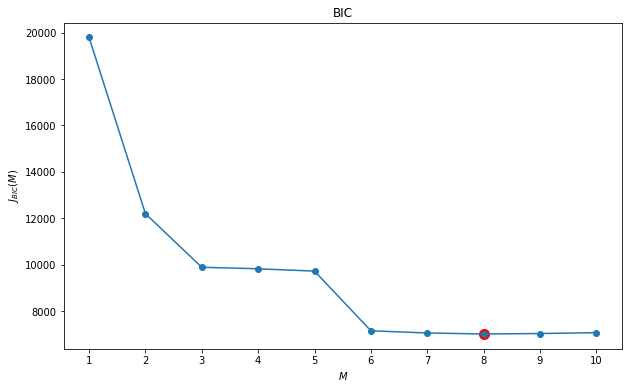

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


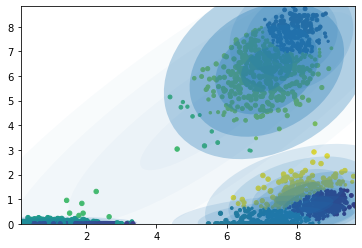

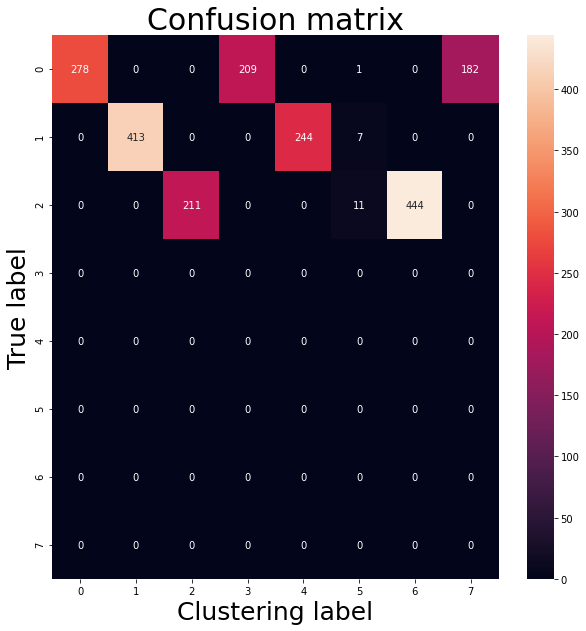

GMM acc: 0.568


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


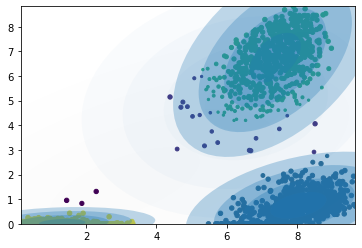

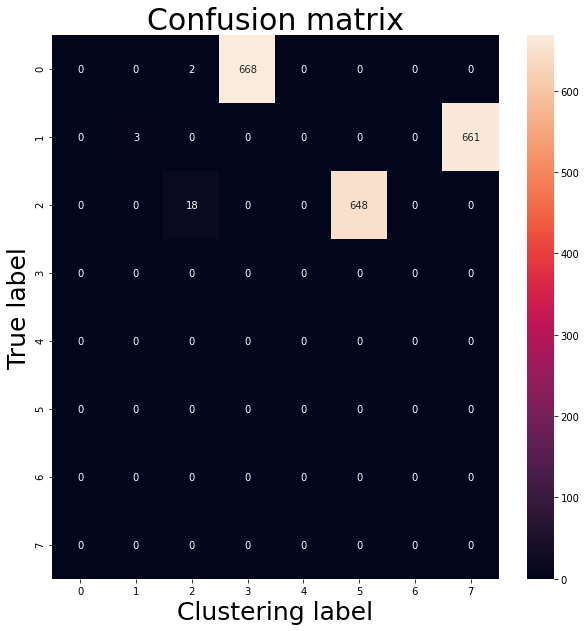

V-GMM acc: 0.989


In [0]:
# CLUSTERING ON EMBEDDED FEATURES
# GMM 
gmm_DEC = clusterizer.GMM()  
gmm_DEC = clusterizer.GMM(gmm_DEC.GMM_generation(encoded, M_range,type='standard', want_to_plot= True)) # fit on data
labels_gmm_DEC = gmm_DEC.prediction(encoded, want_to_plot=True) # prediction
cm_gmm_DEC,acc_gmm_DEC,ind_gmm_DEC = gmm_DEC.confusion_matrix(y_test, labels_gmm_DEC, True) # confusion matrix
gmm_DEC.gmm_model.weights_ = gmm_DEC.gmm_model.weights_[ind_gmm_DEC[:,1]]
gmm_DEC.gmm_model.means_ = gmm_DEC.gmm_model.means_[ind_gmm_DEC[:,1]]
gmm_DEC.gmm_model.covariances_ = gmm_DEC.gmm_model.covariances_[ind_gmm_DEC[:,1]]
print("GMM acc: %5.3f" %(acc_gmm_DEC))

# V-GMM 
vgmm_DEC = clusterizer.GMM()  
vgmm_DEC = clusterizer.GMM(vgmm_DEC.GMM_generation(encoded, M_range,type='bayesian', weight_concentration_prior_type='dirichlet_process', weight_concentration_prior=1.0E-7, want_to_plot= True)) # fit on data
labels_vgmm_DEC = vgmm_DEC.prediction(encoded,want_to_plot=True) # prediction
cm_vgmm_DEC,acc_vgmm_DEC,ind_vgmm_DEC = vgmm_DEC.confusion_matrix(y_test, labels_vgmm_DEC, True) # confusion matrix
vgmm_DEC.gmm_model.weights_ = vgmm_DEC.gmm_model.weights_[ind_vgmm_DEC[:,1]]
vgmm_DEC.gmm_model.means_ = vgmm_DEC.gmm_model.means_[ind_vgmm_DEC[:,1]]
vgmm_DEC.gmm_model.covariances_ = vgmm_DEC.gmm_model.covariances_[ind_vgmm_DEC[:,1]]
print("V-GMM acc: %5.3f" %(acc_vgmm_DEC))

# # Kmeans
# K_range = M_range
# kmeans_DEC = clusterizer.kMeans()  
# models = kmeans_DEC.kmeans_generation(encoded,K_range, True) # fit models on data
# best_model_idx = M#-1
# while best_model_idx not in K_range:
#   best_model_idx = int(input("Number of clusters? "))
# kmeans_DEC = clusterizer.kMeans(models[best_model_idx-1]) # select best model
# labels_kmeans_DEC = kmeans_DEC.prediction(encoded,want_to_plot=True) # prediction
# cm_kmeans_DEC, acc_kmeans_DEC, ind_kmeans_DEC = kmeans_DEC.confusion_matrix(y_test, labels_kmeans_DEC, True) # confusion matrix
# print("KMeans-DEC acc: %5.3f" %(acc_kmeans_DEC))


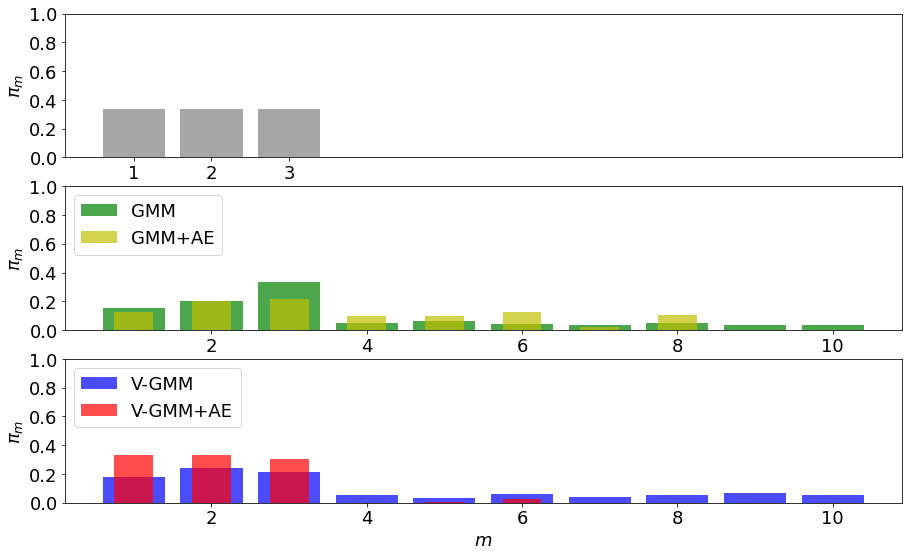

ESTIMATION RESULTS:  
M= 3 
M_gmm_est = 10 
M_vgmm_est = 10 
M_gmm_DEC_est = 8 
M_vgmm_DEC_est = 8
acc_gmm= 0.6891 
acc_vgmm = 0.6363 
acc_gmm_DEC = 0.5675 
acc_vgmm_DEC = 0.9885


In [0]:
# CLUSTERING PERFORMANCE 

# ESTIMATED NUMBER OF EVENTS
# bar chart of the weights of each component 
fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot(3,1,1)
ax1.bar(range(1,M_max+1),np.hstack((p_events,np.zeros(M_max-M))),align='center', alpha=0.7,color=(0.5,0.5,0.5))
ax1.set_xticks(range(1,M+1))
plt.xlabel(r'$m$',fontsize=18)
plt.ylabel(r'$\pi_m$',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([0,1])
ax2 = plt.subplot(3,1,2)
ax2.bar(range(1,len(gmm.gmm_model.weights_)+1),gmm.gmm_model.weights_,align='center',label='GMM', color='g', alpha=0.7)
ax2.bar(range(1,len(gmm_DEC.gmm_model.weights_)+1),gmm_DEC.gmm_model.weights_,align='center', label='GMM+AE', width=0.5,color='y', alpha=0.7)
ax2.legend(fontsize=18, loc='upper left')
plt.xlabel(r'$m$',fontsize=18)
plt.ylabel(r'$\pi_m$',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([0,1])
ax3 = plt.subplot(3,1,3)
ax3.bar(range(1,len(vgmm.gmm_model.weights_)+1),vgmm.gmm_model.weights_,align='center',label='V-GMM', color='b', alpha=0.7)
ax3.bar(range(1,len(vgmm_DEC.gmm_model.weights_)+1),vgmm_DEC.gmm_model.weights_,align='center', label='V-GMM+AE', width=0.5,color='r', alpha=0.7)
ax3.legend(fontsize=18, loc='upper left')
plt.xlabel(r'$m$',fontsize=18)
plt.ylabel(r'$\pi_m$',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([0,1])
plt.show()
# estimated number of events
M_gmm_est = np.array(labels_gmm).max()+1
M_vgmm_est = np.array(labels_vgmm).max()+1
M_gmm_DEC_est = np.array(labels_gmm_DEC).max()+1
M_vgmm_DEC_est = np.array(labels_vgmm_DEC).max()+1
print("ESTIMATION RESULTS:  \nM= {} \nM_gmm_est = {} \nM_vgmm_est = {} \nM_gmm_DEC_est = {} \nM_vgmm_DEC_est = {}".format(M,M_gmm_est,M_vgmm_est,M_gmm_DEC_est,M_vgmm_DEC_est))

# ACCURACY
print("acc_gmm= {} \nacc_vgmm = {} \nacc_gmm_DEC = {} \nacc_vgmm_DEC = {}".format(acc_gmm, acc_vgmm,acc_gmm_DEC,acc_vgmm_DEC))


In [0]:
# HYPERCUBE REPROJECTION 

# map each cluster centroid to the closest hypercube vertex and discover how many EFFECTIVE clusters are
# detected and how many of these coincide with the TRUE ones (reconstruction accuracy)

# GMM
mu_gmm_projected = np.round(gmm.gmm_model.means_).astype(int)
gmm2tau = np.zeros(M,dtype=int) # how many clusters are projected onto the true vertices
gmm_err = 0 # how many new (fake) clusters are created
gmm_tau = {} # dictionary of reconstructed hypercube vertices (keys) and corresponding weights (values)
for k in range(len(mu_gmm_projected)):
  mu = mu_gmm_projected[k]
  wrong_reconstruction = True
  for m in range(M):
    if np.count_nonzero(tau[m,:] != mu) == 0:
      gmm2tau[m] += 1
      if str(tau[m,:]) not in gmm_tau.keys():
        gmm_tau[str(tau[m,:])] = gmm.gmm_model.weights_[k]
      else:
        gmm_tau[str(tau[m,:])] += gmm.gmm_model.weights_[k]
      wrong_reconstruction = False
  if wrong_reconstruction:
    gmm_err += gmm.gmm_model.weights_[k]
    if str(mu) not in gmm_tau.keys():
      gmm_tau[str(mu)] = gmm.gmm_model.weights_[k]
    else:
      gmm_tau[str(mu)] += gmm.gmm_model.weights_[k]

# V-GMM
mu_vgmm_projected = np.round(vgmm.gmm_model.means_).astype(int)
vgmm2tau = np.zeros(M,dtype=int) # how many clusters are projected onto the true vertices
vgmm_err = 0 # how many new (fake) clusters are created
vgmm_tau = {} # dictionary of reconstructed hypercube vertices (keys) and corresponding weights (values)
for k in range(len(mu_vgmm_projected)):
  mu = mu_vgmm_projected[k]
  wrong_reconstruction = 1
  for m in range(M):
    if np.count_nonzero(tau[m,:] != mu) == 0:
      vgmm2tau[m] += 1
      if str(tau[m,:]) not in vgmm_tau.keys():
        vgmm_tau[str(tau[m,:])] = vgmm.gmm_model.weights_[k]
      else:
        vgmm_tau[str(tau[m,:])] += vgmm.gmm_model.weights_[k]
      wrong_reconstruction = 0
  if wrong_reconstruction:
    vgmm_err += vgmm.gmm_model.weights_[k]
    if str(mu) not in vgmm_tau.keys():
      vgmm_tau[str(mu)] = vgmm.gmm_model.weights_[k]
    else:
      vgmm_tau[str(mu)] += vgmm.gmm_model.weights_[k]

# GMM + AE
mu_gmm_DEC_decoded_projected = np.round(scaler.inverse_transform( ae.decoder.predict(gmm_DEC.gmm_model.means_))).astype(int)
gmm_DEC2tau = np.zeros(M,dtype=int) # how many clusters are projected onto the true vertices
gmm_DEC_err = 0 # how many new (fake) clusters are created
gmm_DEC_tau = {} # dictionary of reconstructed hypercube vertices (keys) and corresponding weights (values)
for k in range(len(mu_gmm_DEC_decoded_projected)):
  mu = mu_gmm_DEC_decoded_projected[k]
  wrong_reconstruction = 1
  for m in range(M):
    if np.count_nonzero(tau[m,:] != mu) == 0:
      gmm_DEC2tau[m] += 1
      if str(tau[m,:]) not in gmm_DEC_tau.keys():
        gmm_DEC_tau[str(tau[m,:])] = gmm_DEC.gmm_model.weights_[k]
      else:
        gmm_DEC_tau[str(tau[m,:])] += gmm_DEC.gmm_model.weights_[k]
      wrong_reconstruction = 0
  if wrong_reconstruction:
    gmm_DEC_err += gmm_DEC.gmm_model.weights_[k]
    if str(mu) not in gmm_DEC_tau.keys():
      gmm_DEC_tau[str(mu)] = gmm_DEC.gmm_model.weights_[k]
    else:
      gmm_DEC_tau[str(mu)] += gmm_DEC.gmm_model.weights_[k]

# V-GMM + AE
mu_vgmm_DEC_decoded_projected = np.round(scaler.inverse_transform( ae.decoder.predict(vgmm_DEC.gmm_model.means_))).astype(int) 
vgmm_DEC2tau = np.zeros(M,dtype=int) # how many clusters are projected onto the true vertices
vgmm_DEC_err = 0 # how many new (fake) clusters are created
vgmm_DEC_tau = {} # dictionary of reconstructed hypercube vertices (keys) and corresponding weights (values)
for k in range(len(mu_vgmm_DEC_decoded_projected)):
  mu = mu_vgmm_DEC_decoded_projected[k]
  wrong_reconstruction = 1
  for m in range(M):
    if np.count_nonzero(tau[m,:] != mu) == 0:
      vgmm_DEC2tau[m] += 1
      if str(tau[m,:]) not in vgmm_DEC_tau.keys():
        vgmm_DEC_tau[str(tau[m,:])] = vgmm_DEC.gmm_model.weights_[k]
      else:
        vgmm_DEC_tau[str(tau[m,:])] += vgmm_DEC.gmm_model.weights_[k]
      wrong_reconstruction = 0
  if wrong_reconstruction:
    vgmm_DEC_err += vgmm_DEC.gmm_model.weights_[k]
    if str(mu) not in vgmm_DEC_tau.keys():
      vgmm_DEC_tau[str(mu)] = vgmm_DEC.gmm_model.weights_[k]
    else:
      vgmm_DEC_tau[str(mu)] += vgmm_DEC.gmm_model.weights_[k]

print("Number of correct assignments:\ngmm2tau= {} \nvgmm2tau = {} \ngmm_DEC2tau = {} \nvgmm_DEC2tau = {}".format(gmm2tau,vgmm2tau,gmm_DEC2tau,vgmm_DEC2tau))
print("\nReconstruction error:\ngmm_err= {} \nvgmm_err = {} \ngmm_DEC_err = {} \nvgmm_DEC_err = {}".format(gmm_err,vgmm_err,gmm_DEC_err,vgmm_DEC_err))

Number of correct assignments:
gmm2tau= [1 2 1] 
vgmm2tau = [1 1 1] 
gmm_DEC2tau = [3 2 3] 
vgmm_DEC2tau = [2 1 2]

Reconstruction error:
gmm_err= 0.26355809430657773 
vgmm_err = 0.3640052004762578 
gmm_DEC_err = 0 
vgmm_DEC_err = 0.0015867936173686698


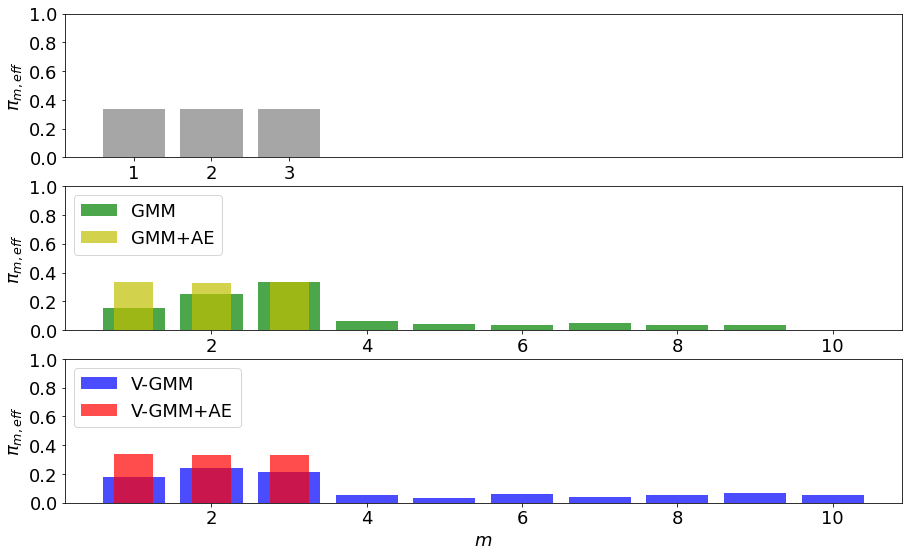

REPROJECTION RESULTS:  
M= 3 
M_gmm_eff = 9 
M_vgmm_eff = 10 
M_gmm_DEC_eff = 3 
M_vgmm_DEC_eff = 4


In [0]:
# HYPERCUBE REPROJECTION PERFORMANCE

# ESTIMATED NUMBER OF EFFECTIVE EVENTS
# bar chart of the weights of each effective component 
fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot(3,1,1)
ax1.bar(range(1,M_max+1),np.hstack((p_events,np.zeros(M_max-M))),align='center', alpha=0.7,color=(0.5,0.5,0.5))
ax1.set_xticks(range(1,M+1))
plt.xlabel(r'$m$',fontsize=18)
plt.ylabel(r'$\pi_{m,eff}$',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([0,1])
ax2 = plt.subplot(3,1,2)
ax2.bar(range(1,M_max+1),np.hstack((list(gmm_tau.values()),np.zeros(M_max-len(gmm_tau.values())))),align='center',label='GMM', color='g', alpha=0.7)
ax2.bar(range(1,M_max+1),np.hstack((list(gmm_DEC_tau.values()),np.zeros(M_max-len(gmm_DEC_tau.values())))),align='center', label='GMM+AE', width=0.5,color='y', alpha=0.7)
ax2.legend(fontsize=18, loc='upper left')
plt.xlabel(r'$m$',fontsize=18)
plt.ylabel(r'$\pi_{m,eff}$',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([0,1])
ax3 = plt.subplot(3,1,3)
ax3.bar(range(1,M_max+1),np.hstack((list(vgmm_tau.values()),np.zeros(M_max-len(vgmm_tau.values())))),align='center',label='V-GMM', color='b', alpha=0.7)
ax3.bar(range(1,M_max+1),np.hstack((list(vgmm_DEC_tau.values()),np.zeros(M_max-len(vgmm_DEC_tau.values())))),align='center', label='V-GMM+AE', width=0.5,color='r', alpha=0.7)
ax3.legend(fontsize=18, loc='upper left')
plt.xlabel(r'$m$',fontsize=18)
plt.ylabel(r'$\pi_{m,eff}$',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([0,1])
plt.show()
# estimated number of effective events
M_gmm_eff = len(list(gmm_tau.values()))
M_vgmm_eff = len(list(vgmm_tau.values()))
M_gmm_DEC_eff = len(list(gmm_DEC_tau.values()))
M_vgmm_DEC_eff = len(list(vgmm_DEC_tau.values()))
print("REPROJECTION RESULTS:  \nM= {} \nM_gmm_eff = {} \nM_vgmm_eff = {} \nM_gmm_DEC_eff = {} \nM_vgmm_DEC_eff = {}".format(M,M_gmm_eff,M_vgmm_eff,M_gmm_DEC_eff,M_vgmm_DEC_eff))
